In [106]:
'''%pip install ultralytics
%pip install pyfacer
%pip install timm
%pip install scikit-learn
%pip install Pillow'''
import os
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.image as mpimg
from PIL import Image as PILImage
import shutil
from tkinter import Image
import numpy as np
from sklearn.cluster import KMeans
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor
import facer
import time

In [107]:
class Segmentation:
    def __init__(self):
        self._project_dir = os.getcwd()
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self._face_detector = facer.face_detector('retinaface/mobilenet', device=self._device)
        self._face_parser = facer.face_parser('farl/lapa/448', device=self._device)

    def process_images(self):
        # Inizializza una variabile per i volti
        faces = None
        
        # Itera attraverso i file nella directory 'results/faces'
        for filename in os.listdir(os.path.join(self._project_dir, 'results/faces')):
            # Legge l'immagine corrente e la converte in un tensore per elaborazione
            image = facer.hwc2bchw(facer.read_hwc(f'results/faces/{filename}')).to(device=self._device)
            
            # Esegue il rilevamento dei volti sull'immagine
            with torch.inference_mode():
                faces = self._face_detector(image)
            facer.show_bchw(facer.draw_bchw(image, faces))

            # Esegue l'analisi dei volti sull'immagine
            with torch.inference_mode():
                faces = self._face_parser(image, faces)

            # Ottiene le previsioni di segmentazione dai volti
            seg_logits = faces['seg']['logits']
            seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
            
            # Calcola il numero di classi di segmentazione
            n_classes = seg_probs.size(1)

            all_segments = []
            for face_id in range(seg_probs.size(0)):
                for class_id in range(n_classes):
                    mask = (seg_probs[face_id, class_id] > 0.5).float()
                    if mask.sum() > 0:
                        mask_pil = to_pil_image(mask.cpu())
                        print(mask)
                        all_segments.append((face_id, class_id, mask))

            '''for (face_id, class_id, mask_pil) in all_segments:
                mask_pil.show(title=f'Face {face_id} - Class {class_id}')'''
            
            # Calcola un'immagine visibile basata sulle previsioni di segmentazione
            vis_seg_probs = seg_probs.argmax(dim=1).float() / n_classes * 255
            vis_img = vis_seg_probs.sum(0, keepdim=True)
            facer.show_bhw(vis_img)
            facer.show_bchw(facer.draw_bchw(image, faces))

            # Converte il tensore in un'immagine PIL
            vis_img_pil = to_pil_image(vis_img.byte())

            # Crea una directory per le immagini risultanti se non esiste già
            directory = "results/faces_facer"
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Salva l'immagine risultante nella directory 'results/faces_facer', rinominandola
            vis_img_pil.save(os.path.join(directory,f'result_{filename.split("_")[1]}_{filename.split("_")[2]}'), format='JPEG')

        # Restituisce l'oggetto faces
        return all_segments
    
    def extract_dominant_colors(self, all_segments, filename='result_0_0.jpg'):
        dominant_colors = {}
        image_path = os.path.join(self._project_dir, 'results/faces', filename)
        image = facer.read_hwc(image_path)
        image_tensor = facer.hwc2bchw(image).to(device=self._device)

        for part_segmented in all_segments:
            # Get the coordinates where the segmentation mask is non-zero
            pixel_coords = torch.nonzero(part_segmented[2])
            segmented_colors = []
            for coord in pixel_coords:
                color = image_tensor[0, :, coord[0], coord[1]].cpu().numpy()
                segmented_colors.append(color)
            if len(segmented_colors) > 0:
                segmented_colors = np.array(segmented_colors)
                kmeans = KMeans(n_clusters=3).fit(segmented_colors)
                dominant_colors[part_segmented[1]] = kmeans.cluster_centers_

        return dominant_colors

In [108]:
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO

class FaceDetection:
    def __init__(self):
        # Ottieni il percorso completo del file
        self._project_dir = os.getcwd()
        # Percorso del modello
        self._model_path = os.path.join(self._project_dir, 'data/models/yolov8l-face.pt')
        # Assicurati che il percorso del modello sia corretto
        assert os.path.exists(self._model_path), f"Il percorso del modello non è valido"
        # Inizializza il modello YOLO
        self._model = YOLO(self._model_path)
        print("Inizializzazione...")

    def face_detection(self, input_dir='data/images', output_dir='results/faces'):
        # Elenco dei file nella cartella di input
        image_files = os.listdir(input_dir)

        # Assicurati che l'output_dir esista, altrimenti crealo
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        print("Directory creata")

        start_time = time.time()
        timeout_seconds=50

        # Itera su ogni file di immagine nella cartella di input
        for image_file in image_files:
            # Percorso completo dell'immagine di input
            image_path = os.path.join(input_dir, image_file)
            
            # Esegui l'inferenza sull'immagine con YOLOv8
            results = self._model(image_path)

            # Itera attraverso tutte le bounding box individuate
            for i, result in enumerate(results):
                boxes = result.boxes.data  # Boxes object for bounding box outputs

                """ result.save(filename='results/result.jpg')
                img = mpimg.imread('results/result.jpg')
                plt.imshow(img) """

                for j, box in enumerate(boxes):
                    # Ottieni le coordinate della bounding box
                    x_min, y_min, x_max, y_max, conf, cls = box.tolist()[:6]

                    # Ritaglia l'area corrispondente dall'immagine originale
                    img = Image.open(image_path)
                    cropped_img = img.crop((x_min, y_min, x_max, y_max))

                    # Salva l'immagine ritagliata
                    output_file = f'result_{i}_{j}.jpg'
                    image_file_no_extension = image_file.split('.')[0]
                    #output_file = f'result_{image_file_no_extension}_box_{i}_{j}.jpg'
                    cropped_img.save(os.path.join(output_dir, output_file))
                if time.time() - start_time >= timeout_seconds:
                    print("Timeout raggiunto. Uscita dal ciclo.")
                    return
        print("Processo concluso con successo")


In [109]:
fd = FaceDetection()
#fd.face_detection('C:\\Users\\gians_ji5genm\\OneDrive - Università Politecnica delle Marche\\UNIVPM\\Computer Visione e Deep Learning\\Progetto\\CelebAMask-HQ\\CelebAMask-HQ\\CelebA-HQ-img', 'C:\\Users\\gians_ji5genm\\OneDrive - Università Politecnica delle Marche\\UNIVPM\\Computer Visione e Deep Learning\\Progetto\\Risultati')
fd.face_detection()

Inizializzazione...
Directory creata

image 1/1 c:\Users\dswal\Desktop\CV-DL-Armocromia\data\images\Faces.jpg: 544x960 1 face, 3023.0ms
Speed: 14.6ms preprocess, 3023.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 960)
Processo concluso con successo


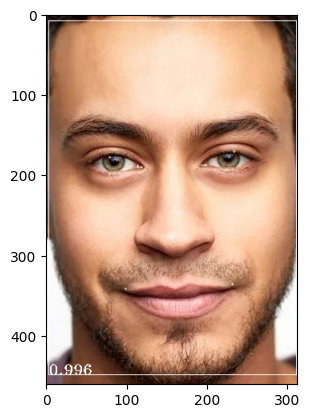

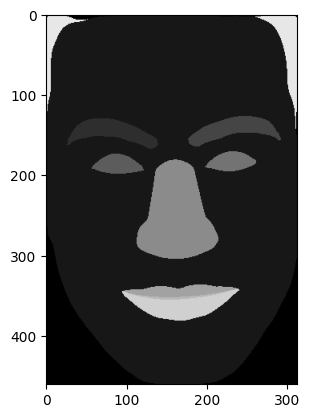

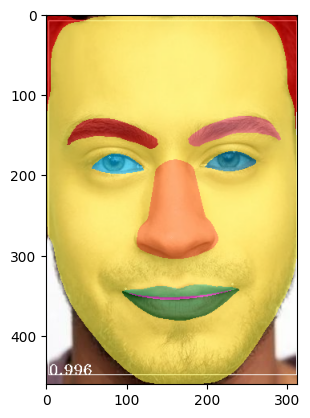

In [110]:
sg= Segmentation()
faces = sg.process_images()

In [124]:
colors = sg.extract_dominant_colors(faces)
print(colors)


{0: array([[     86.965,      50.846,      34.781],
       [     244.95,      243.68,      243.05],
       [     153.57,      103.97,      83.654]]), 1: array([[     112.07,      70.494,      50.026],
       [     199.73,      140.34,      106.11],
       [     248.62,      205.18,      173.19]]), 2: array([[     107.15,      66.406,      48.674],
       [     157.92,      109.36,      87.179],
       [     63.381,      33.223,        20.5]]), 3: array([[     77.547,      43.516,      29.343],
       [     175.49,      125.34,      101.47],
       [     126.94,      79.189,       57.14]]), 4: array([[     130.86,      108.62,      90.449],
       [     52.817,      33.419,      24.198],
       [     216.89,      185.12,      167.63]]), 5: array([[     136.82,      107.91,      90.096],
       [     55.806,      36.215,      25.766],
       [     208.97,       171.3,      151.57]]), 6: array([[     251.12,      208.71,      179.95],
       [     117.13,      58.964,      43.756],
      

In [125]:
# Normalizza i valori RGB nel range [0, 1]
for key, values in colors.items():
    colors[key] = np.array(values) / 255.0

0


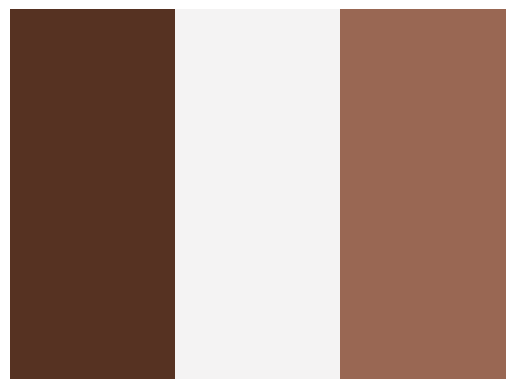

1


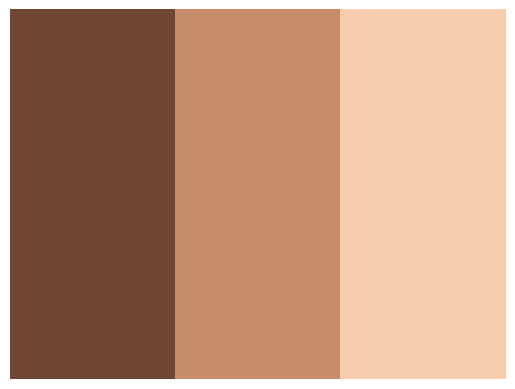

2


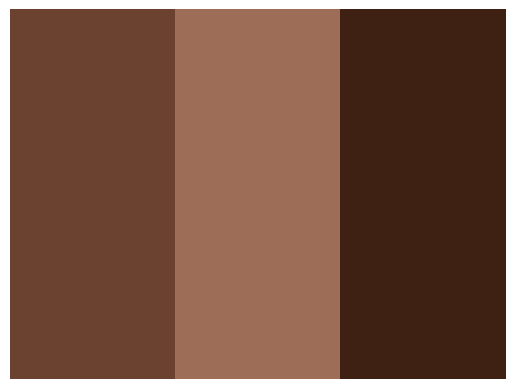

3


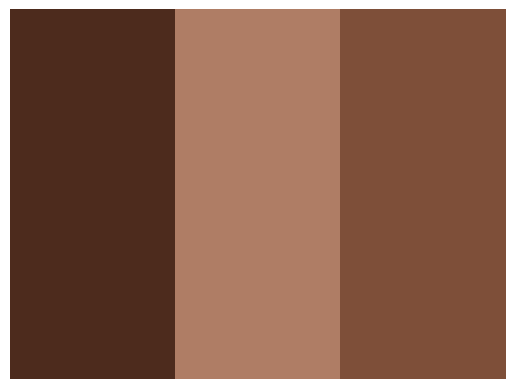

4


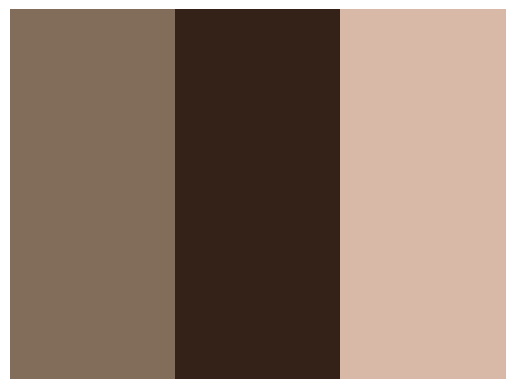

5


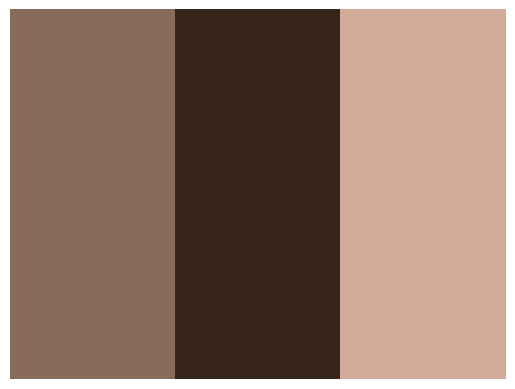

6


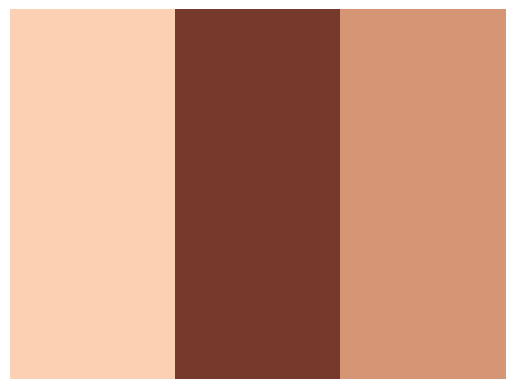

7


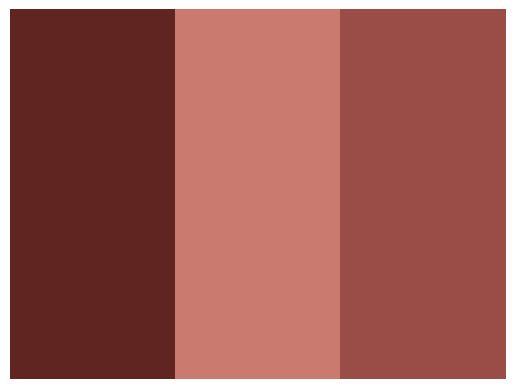

8


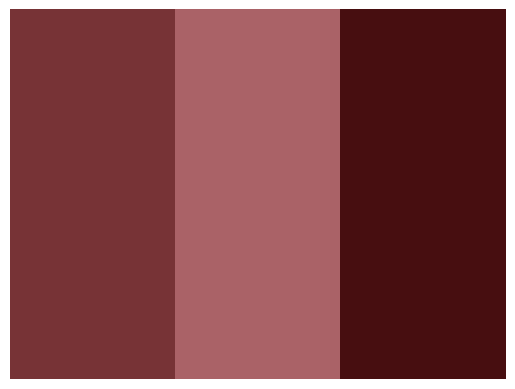

9


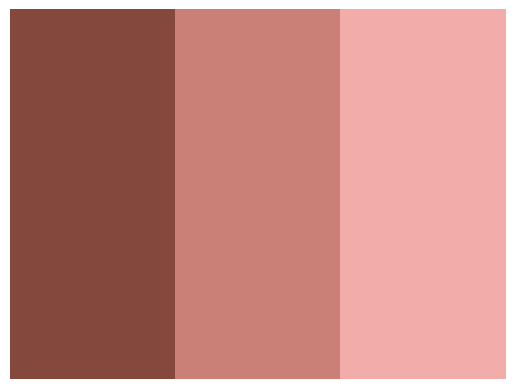

10


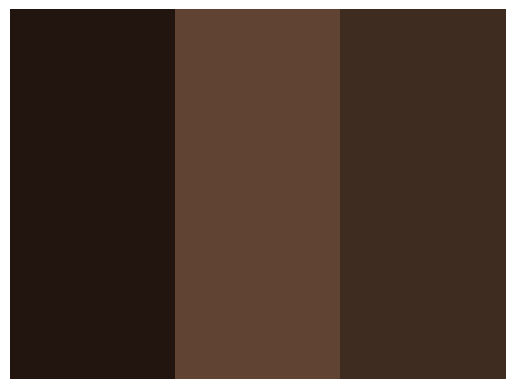

In [126]:
# Mostra i colori
for key, values in colors.items():
    print(key)
    fig, ax = plt.subplots()
    ax.imshow([values], aspect='auto')
    ax.axis('off')
    plt.show()

### Parte sotto da non considerare

In [112]:
# Percorso del modello
model_path = os.path.join(project_dir, 'yolov8l-face.pt')

# Assicurati che il percorso del modello sia corretto
assert os.path.exists(model_path), f"Il percorso del modello non è valido"
# Run inference on an image with YOLOv8
model = YOLO(model_path)
results = model(os.path.join(project_dir, 'Faces.jpg'))

NameError: name 'project_dir' is not defined

In [ ]:
for i, result in enumerate(results):
    boxes = result.boxes.data  # Boxes object for bounding box outputs

    result.save(filename='result.jpg')
    img = mpimg.imread('result.jpg')
    plt.imshow(img)
    # Itera attraverso tutte le bounding box individuate
    for j, box in enumerate(boxes):
        # Ottieni le coordinate della bounding box
        x_min, y_min, x_max, y_max, conf, cls = box.tolist()[:6]

        # Ritaglia l'area corrispondente dall'immagine originale
        img = Image.open(os.path.join(project_dir, 'Faces.jpg'))
        cropped_img = img.crop((x_min, y_min, x_max, y_max))

        # Salva l'immagine ritagliata
        directory = "faces"
        # Controllo se la cartella esiste, altrimenti la creo
        if not os.path.exists(directory):
            os.makedirs(directory)
        #shutil.rmtree(directory)
        cropped_img.save(os.path.join(directory,f'result_{i}_{"0" * (len(str(len(boxes))) - len(str(j)))}{j}.jpg'))